In [1]:
!pip install geopandas requests tqdm shapely


In [2]:
import zipfile
with zipfile.ZipFile("/content/MidTown_CLIPPED.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/midtown_buildings")


In [3]:
import geopandas as gpd
import pandas as pd
import requests
from shapely.geometry import Point
from tqdm import tqdm
import time

In [11]:
# Load the shapefile
buildings = gpd.read_file("/content/midtown_buildings/MidTown_CLIPPED.shp")

# Check the original CRS
print("Original CRS:", buildings.crs)

# Reproject to WGS84 (latitude & longitude in degrees)
buildings = buildings.to_crs(epsg=4326)
print("New CRS:", buildings.crs)


Original CRS: EPSG:2263
New CRS: EPSG:4326


In [9]:
# Reproject from projected CRS to geographic coordinates (WGS84)
buildings = buildings.to_crs(epsg=4326)


In [12]:
# Compute centroids AFTER reprojection
buildings["centroid"] = buildings.geometry.centroid
buildings["lon"] = buildings.centroid.x
buildings["lat"] = buildings.centroid.y

# Preview values
buildings[["lat", "lon"]].head()


/tmp/ipython-input-703401850.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings["centroid"] = buildings.geometry.centroid
/tmp/ipython-input-703401850.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings["lon"] = buildings.centroid.x
/tmp/ipython-input-703401850.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings["lat"] = buildings.centroid.y


,lat,lon
0,40.754424,-73.985773
1,40.754979,-73.985915
2,40.755315,-73.986041
3,40.755190,-73.985650
4,40.755107,-73.986229


In [13]:
solar_kwh_per_kw = []
url = "https://re.jrc.ec.europa.eu/api/v5_2/PVcalc"

for i, row in tqdm(buildings.iterrows(), total=len(buildings)):
    lat = row['lat']
    lon = row['lon']

    if pd.isna(lat) or pd.isna(lon):
        solar_kwh_per_kw.append(None)
        continue

    params = {
        "lat": lat,
        "lon": lon,
        "peakpower": 1,
        "loss": 14,
        "angle": 30,
        "aspect": 0,
        "outputformat": "json"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        value = data["outputs"]["totals"]["fixed"]["E_y"]
        solar_kwh_per_kw.append(value)
    except Exception as e:
        print(f"⚠️ Error at index {i} (lat: {lat}, lon: {lon}): {e}")
        solar_kwh_per_kw.append(None)

    time.sleep(1.0)  # delay to avoid PVGIS rate limits


100%|██████████| 998/998 [27:09<00:00,  1.63s/it]


In [20]:
buildings["solar_kwh_per_kw"] = solar_kwh_per_kw
buildings[["lat", "lon", "solar_kwh_per_kw"]].head()


,lat,lon,solar_kwh_per_kw
0,40.754424,-73.985773,1357.14
1,40.754979,-73.985915,1357.16
2,40.755315,-73.986041,1357.16
3,40.755190,-73.985650,1357.16
4,40.755107,-73.986229,1357.16


In [15]:
# Remove extra geometry
buildings = buildings.drop(columns=["centroid"])

# Export to files
buildings.to_file("/content/midtown_solar.geojson", driver="GeoJSON")
buildings[["lat", "lon", "solar_kwh_per_kw"]].to_csv("/content/midtown_solar.csv", index=False)


In [16]:
from google.colab import files
files.download("/content/midtown_solar.geojson")
files.download("/content/midtown_solar.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Estimate rooftop area (only if 'Shape_Area' or similar exists)
if "Shape_Area" in buildings.columns:
    buildings["total_kwh"] = buildings["solar_kwh_per_kw"] * (buildings["Shape_Area"] / 10)  # assuming 0.1 kW/m²
else:
    buildings["total_kwh"] = buildings["solar_kwh_per_kw"]  # fallback

# Summary
buildings["total_kwh"].describe()


,total_kwh
count,9.980000e+02
mean,1.331276e+06
std,4.084267e+06
min,2.444377e+03
25%,3.069913e+05
50%,3.809297e+05
75%,1.095424e+06
max,7.040589e+07


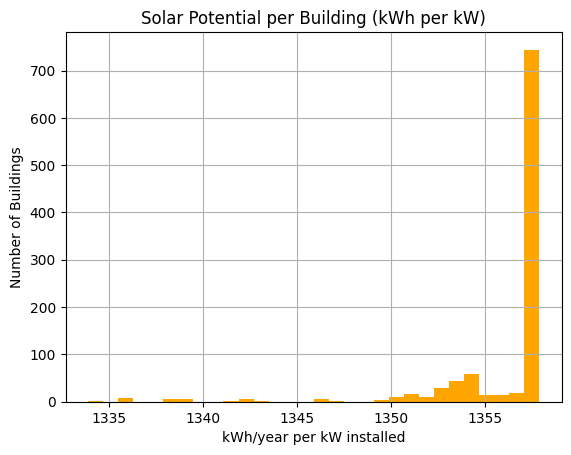

In [18]:
import matplotlib.pyplot as plt

buildings["solar_kwh_per_kw"].hist(bins=30, color='orange')
plt.title("Solar Potential per Building (kWh per kW)")
plt.xlabel("kWh/year per kW installed")
plt.ylabel("Number of Buildings")
plt.grid(True)
plt.show()


In [19]:
top = buildings.sort_values("solar_kwh_per_kw", ascending=False).head(10)
top[["lat", "lon", "solar_kwh_per_kw"]]


,lat,lon,solar_kwh_per_kw
789,40.764671,-73.996235,1357.86
773,40.764472,-73.998085,1357.86
790,40.764720,-73.996351,1357.86
791,40.764568,-73.995992,1357.86
792,40.765064,-73.996000,1357.86
785,40.765041,-73.997496,1357.86
777,40.764817,-73.996926,1357.86
715,40.764336,-73.994258,1357.85
776,40.764252,-73.997388,1357.85
767,40.764425,-73.997688,1357.85
